In [25]:
from google import genai
import json
from typing import Generator, Iterator
import nltk
from nltk import sent_tokenize
from nltk.stem import PorterStemmer


In [ ]:
# nltk.download("popular")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [16]:
with open(".env", "r") as f:
    API_KEY = f.readline()
MODEL = "gemini-2.5-flash-lite"

client = genai.Client(api_key=API_KEY)

def gemini(text: str) -> genai.types.GenerateContentResponse:
    return client.models.generate_content(model=MODEL, contents=text)

In [17]:
with open("longbench.json", "r", encoding="utf-8") as f:
    longbench = json.load(f)

In [18]:
def allWithQuality(kvPairs: list[tuple[str, str]]) -> Generator:
    for item in longbench:
        if all(item[k] == v for k,v in kvPairs):
            yield item

In [6]:
# response = gemini("What would you make the 27th letter of the alphabet")

In [10]:
for bench in allWithQuality([("difficulty", "easy"), ("length", "long")]):
    print(bench["question"])
    with open("out.txt", "w", encoding="utf-8") as f:
        f.write(bench["context"])
    break

In the function that calculates the derivative of given functions, which of the following keyword arguments are all recognized?


In [47]:
CHAR_TO_TOKEN_RATIO = .25
EPSILON = 1.1
TOKEN_LIMIT = 4096

# str.split() except it makes sure we don't make any tiny splits
def splitMinLength(s: str, splitChar: str, minLength: int) -> list[str]:
    i = 0
    ret = []
    while i < len(s):
        item = ""
        while i < len(s):
            item += s[i]
            if item.endswith(splitChar) and len(item) >= minLength: 
                ret.append(item)
                break
            i += 1
        i += 1
    return ret

def chunkify(context: str, splitChar: str, minLength: int) -> Iterator[str]:    
    i = 0
    # splitContext = splitMinLength(context, splitChar, minLength)
    splitContext = [i + splitChar for i in context.split(splitChar)]
    while i < len(splitContext):
        chunk = ""
        collected = 0
        while i < len(splitContext) \
        and (len(splitContext[i]) * CHAR_TO_TOKEN_RATIO + collected) * EPSILON < TOKEN_LIMIT:
            chunk += splitContext[i]
            collected += (len(splitContext[i]) * CHAR_TO_TOKEN_RATIO)
            i += 1

        # If single chunk is still too big with current strategy fall back to simpler strat
        if chunk == "" and i < len(splitContext):
            if splitChar != "\n":
                yield from chunkify_lineBreaks(splitContext[i])
            else:
                yield from chunkify_naive(splitContext[i])
            i += 1
        elif chunk != "":
            yield chunk

def chunkify_lineBreaks(context: str) -> Iterator[str]:
    yield from chunkify(context, "\n", 0)

def chunkify_periods(context: str) -> Iterator[str]:
    yield from chunkify(context, ".", 50)

def chunkify_blankLines(context: str) -> Iterator[str]:
    yield from chunkify(context, "\n\n", 200)

def chunkify_naive(context: str) -> Iterator[str]:
    i = 0
    charsToSkip = int(TOKEN_LIMIT / CHAR_TO_TOKEN_RATIO / EPSILON)
    while i + charsToSkip < len(context):
        yield context[i:i+charsToSkip]
        i += charsToSkip
    yield context[i:]

def chunkify_nltk(context: str) -> Iterator[str]:
    runningTotal = 0
    chunk = ""
    for sentence in sent_tokenize(context):
        if (len(sentence) * CHAR_TO_TOKEN_RATIO + runningTotal) * EPSILON >= TOKEN_LIMIT:
            yield chunk
            runningTotal = 0
            chunk = ""
        chunk += sentence + " "
        runningTotal += len(sentence) * CHAR_TO_TOKEN_RATIO
    yield chunk


In [50]:
testbench = longbench[5]
with open("prompts/keyelements.txt", "r", encoding="utf-8") as f:
    prefix = f.read()
prompt = prefix + "\n"
for chunk in chunkify_nltk(testbench["context"]):
    prompt += chunk
    break
print(prompt)

You are now an intelligent assistant tasked with meticulously extracting both key elements and atomic facts from a long text.
1. Key Elements: The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g., actions), and adjectives (e.g., states, feelings) that are pivotal to the text’s narrative.
2. Atomic Facts: The smallest, indivisible facts, presented as concise sentences. These include propositions, theories, existences, concepts, and implicit elements like logic, causality, event sequences, interpersonal relationships, timelines, etc.
Requirements:
#####
1. Ensure that all identified key elements are reflected within the corresponding atomic facts.
2. You should extract key elements and atomic facts comprehensively, especially those that are important and potentially query-worthy and do not leave out details.
3. Whenever applicable, replace pronouns with their specific noun counterparts (e.g., change I, He, She to actual names).
4. Ensure that the key elemen

In [51]:
response = gemini(prompt)

In [52]:
print(response.text)

1. The party was a killer. | party | killer
2. Erin Albright paused to take in the scene. | Erin Albright | paused | scene
3. The music was designed to get people moving and their asses were crowding the dance floor. | music | moving | asses | crowding | dance floor
4. Lights shifted from red to blue to pink, making the atmosphere sexy. | Lights | red | blue | pink | atmosphere | sexy
5. The bartender's generous pours of the signature drink, Girl Power, contributed to the mood. | bartender | generous pours | signature drink | Girl Power | mood
6. They chose a Monday night at the Down and Dirty for the heat, sexiness, and space for a couple dozen friends. | Monday night | Down and Dirty | heat | sexiness | space | couple dozen friends
7. Monday nights at the D&D featured holo-bands, allowing people to join the stage. | Monday nights | D&D | holo-bands | stage
8. Shauna jumped on stage and was given a microphone. | Shauna | jumped onstage | mic
9. Shauna had a voice like a cat in heat an

In [ ]:
from typing import Self
from string import ascii_lowercase

class Node:
    def __init__(self, tag: str) -> None:
        self.tag = tag
        self.facts: list[str] = []
        self.neighbors: list[Self] = []

    def addFact(self, fact: str) -> None:
        self.facts.append(fact)

    def addNeighbor(self, neighbor: Self) -> None:
        self.neighbors.append(neighbor)

In [ ]:
REQ_FREQ = 4

porter = PorterStemmer()
tags: dict[str, int] = {}
fullTags = []

if type(response.text) is str:
    for line in response.text.split("\n"):
        fullAdd = []
        for tag in line.split("|")[1:]:
            tag = tag.lower().strip()
            tag = "".join((c if c.isalnum() else " " for c in tag))
            # tag = porter.stem(tag)

            if tag in tags: tags[tag] += 1
            else: tags[tag] = 0

            fullAdd.append(tag)
        fullTags.append(fullAdd)

tags = {k: v for k,v in tags.items() if v >= REQ_FREQ}
print(sorted(tags.items(), key=lambda x: x[1], reverse=True))


[('eve', 43), ('erin', 35), ('eve dallas', 35), ('roarke', 33), ('erin albright', 31), ('down and dirty', 25), ('crack', 25), ('shauna', 24), ('shauna hunnicut', 24), ('becca', 12), ('monday night', 7), ('confirmed', 7), ('party', 5), ('privacy room', 5), ('officer', 5), ('scene', 4), ('stage', 4), ('sex club', 4), ('peabody', 4), ('identified', 4), ('hen party', 4)]


In [ ]:
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('whaleloops/phrase-bert')

tags = [k for k in tags.keys()]
embeds = model.encode(tags)

In [ ]:
scan = DBSCAN(eps=10, min_samples=2)
clusters = scan.fit_predict(embeds)
print(clusters)

groups: dict[int, list[str]] = {}

for tag, id in zip(tags, clusters):
    id = int(id)
    if id not in groups:
        groups[id] = [tag]
    else:
        groups[id].append(tag)

print({k: v for k,v in groups.items() if k != -1})

[-1  0 -1 -1 -1 -1  1  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
{0: ['erin albright', 'erin'], 1: ['shauna', 'shauna hunnicut']}


In [ ]:
tagStatus = {tag: "valid" for tag in tags}
for id, group in groups.items():
    if id == -1: continue
    l = list(sorted(group, key=len))
    for tag in l[:-1]:
        tagStatus[tag] = l[-1]

erin
shauna


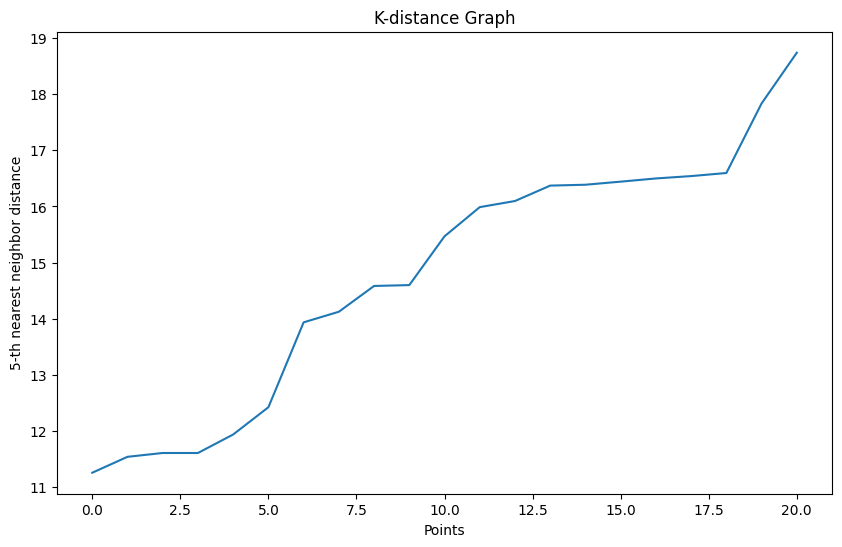

In [101]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(embeds)
distances, _ = neighbors.kneighbors(embeds)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{5}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.show()

In [53]:
with open("out.txt", "w", encoding="utf-8") as f:
    for sent in sent_tokenize(longbench[5]["context"]):
        f.write(f"{sent}\n")


In [ ]:
testbench = longbench[5]
# print(testbench["question"])
with open("out.txt", "w", encoding="utf-8") as f:
    i = 0
    for chunk in chunkify_nltk(testbench["context"]):
        f.write(f"-----Chunk {i+1}-----\n{chunk}\n")
        i += 1
        if i >= 1: break

In [73]:
response = None
for bench in allWithQuality([("difficulty", "easy"), ("length", "short")]):
    # print(bench["question"])
    # print("".join((f"{c}: {bench[f"choice_{c}"]}\n" for c in ["A", "B", "C", "D"])))
    # print(bench["answer"])
    prompt = f"You will be provided long context, and then a multiple choice question. Please attempt to choose the correct answer:\n"
    prompt += f"CONTEXT: {bench["context"]}\n"
    prompt += f"QUESTION: {bench["question"]}\n"
    prompt += ("".join((f"{c}: {bench[f"choice_{c}"]}\n" for c in ["A", "B", "C", "D"])))
    response = gemini(prompt)
    print(response.text)
    break



The question asks how to promote the construction of smart courts. Let's examine the provided text for information related to "smart courts" or "intelligent courts."

Section XI. "Advancing the Construction of Intelligent Courts" directly addresses this topic.
The introductory paragraph states: "Since 2013, the people’s courts have conscientiously implemented the innovation-driven strategy, the national cyber development strategy, the big data strategy, and the new-generation artificial intelligence development plan, and comprehensively strengthened the construction of intelligent courts. The open, and intelligent online Apps have been comprehensively developed, and the main framework of court informatization version 3.0 has been established, which greatly promotes the modernization of the judicial system and judicial capability."

Let's analyze the options:

*   **A: Through technology empowerment, change the way of working and improve office efficiency.** This aligns with the general

In [37]:
with open("out.txt", "w", encoding="utf-8") as f:
    f.write(testbench["context"])

In [12]:
import numpy as np
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer

phrase_list = [ 'play an active role', 'participate actively', 'active lifestyle', "sleepy lifestyle", "active tag", "activate"]

model = SentenceTransformer('whaleloops/phrase-bert')
phrase_embs = model.encode( phrase_list )

In [13]:
for phrase1, emb1 in zip(phrase_list, phrase_embs):
    print(f"----{phrase1}----")
    for phrase2, emb2 in zip(phrase_list, phrase_embs):
        if phrase1 == phrase2: continue
        print(f"{np.linalg.norm(emb1 - emb2)} from '{phrase2}'")


----play an active role----
9.986579895019531 from 'participate actively'
14.458951950073242 from 'active lifestyle'
18.864044189453125 from 'sleepy lifestyle'
15.575200080871582 from 'active tag'
15.343635559082031 from 'activate'
----participate actively----
9.986579895019531 from 'play an active role'
15.094796180725098 from 'active lifestyle'
18.818584442138672 from 'sleepy lifestyle'
17.099464416503906 from 'active tag'
14.40995979309082 from 'activate'
----active lifestyle----
14.458951950073242 from 'play an active role'
15.094796180725098 from 'participate actively'
11.229645729064941 from 'sleepy lifestyle'
15.121877670288086 from 'active tag'
18.791048049926758 from 'activate'
----sleepy lifestyle----
18.864044189453125 from 'play an active role'
18.818584442138672 from 'participate actively'
11.229645729064941 from 'active lifestyle'
17.17343521118164 from 'active tag'
20.367082595825195 from 'activate'
----active tag----
15.575200080871582 from 'play an active role'
17.0994